BERT (Bidirectional Encoder Represntations from Transformers) is a deep learning model that understands the meaning of words in context by reading text in both directions. It’s great for natural language tasks like classification, question answering, and more because it captures how each word relates to the others around it.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#importing libraries
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

In [4]:
df = pd.read_csv('/content/drive/My Drive/phishing_email.csv')
df.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


In [5]:
#exploring the dataset
df.label.value_counts()

,count
label,
1,42891
0,39595


In [6]:
df.describe()

,label
count,82486.000000
mean,0.519979
std,0.499604
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [8]:
df.shape

(82486, 2)

In [9]:
#cleaning the text data
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text
    return ''
df['cleaned_text'] = df['text_combined'].apply(clean_text)

/tmp/ipython-input-10-1545570259.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_name', data=df, palette='viridis')


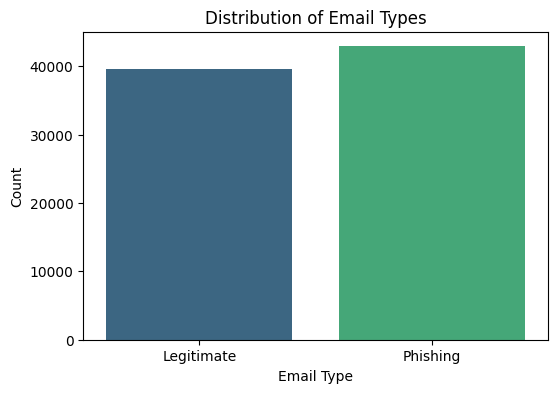

In [10]:
#visualising the class balance
label_map = {0: 'Legitimate', 1: 'Phishing'}
df['label_name'] = df['label'].map(label_map)
plt.figure(figsize=(6, 4))
sns.countplot(x='label_name', data=df, palette='viridis')
plt.xlabel("Email Type")
plt.ylabel("Count")
plt.title("Distribution of Email Types")
plt.show()

This model has higher number of phishing emails compared to safe ones
to prevent this imbalance from affecting the model performance

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text_combined'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [12]:
#creating dataset and datalaoder
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

batch_size = 16
train_dataset = EmailDataset(X_train, y_train, tokenizer)
test_dataset = EmailDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
#defining BERT classifier
class BertEmailClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.classifier(pooled_output)

In [14]:
# Initialize model and optimizer (ONCE)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertEmailClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

epochs = 2  # For demo; use 3-5 for better results

for epoch in range(epochs):
    model.train()
    total_loss = 0
    epoch_start = time.time()

    # Initialize progress bar
    progress_bar = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Epoch {epoch+1}/{epochs}",
        unit='batch'
    )

    for batch_idx, batch in progress_bar:
        batch_start = time.time()

        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update metrics
        total_loss += loss.item()
        batch_time = time.time() - batch_start

        # Update progress bar
        progress_bar.set_postfix({
            'batch_loss': f"{loss.item():.4f}",
            'avg_loss': f"{total_loss/(batch_idx+1):.4f}",
            'time/batch': f"{batch_time:.2f}s"
        })

    # Epoch summary
    epoch_time = time.time() - epoch_start
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} completed | "
          f"Avg Loss: {avg_loss:.4f} | "
          f"Time: {epoch_time//60:.0f}m {epoch_time%60:.0f}s")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/2: 100%|██████████| 4125/4125 [30:16<00:00,  2.27batch/s, batch_loss=0.0002, avg_loss=0.0603, time/batch=0.11s]


Epoch 1/2 completed | Avg Loss: 0.0603 | Time: 30m 16s


Epoch 2/2: 100%|██████████| 4125/4125 [30:30<00:00,  2.25batch/s, batch_loss=0.0002, avg_loss=0.0165, time/batch=0.11s]

Epoch 2/2 completed | Avg Loss: 0.0165 | Time: 30m 30s


BERT Test Accuracy: 0.9932719117468785

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7919
           1       0.99      0.99      0.99      8579

    accuracy                           0.99     16498
   macro avg       0.99      0.99      0.99     16498
weighted avg       0.99      0.99      0.99     16498



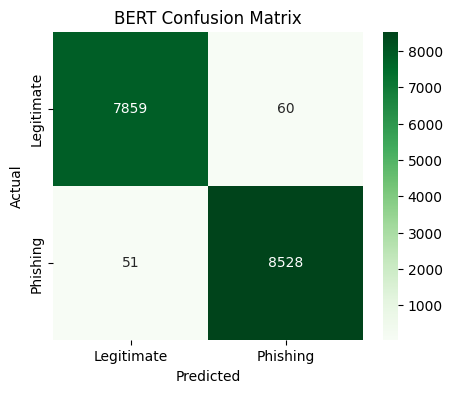

In [15]:
#evaluating the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
print("BERT Test Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("BERT Confusion Matrix")
plt.show()

Accuracy: 99.33%

Precision, Recall, F1-score: All 0.99 for both classes (Legitimate and Phishing)

Confusion Matrix:

Legitimate emails correctly classified: 7859

Phishing emails correctly classified: 8528

Legitimate misclassified as phishing: 60

Phishing misclassified as legitimate: 51

Error: Out of 16,498 emails, only 111 were misclassified

In [16]:
def predict_email(text):
    model.eval()
    encoding = tokenizer(
        text,
        padding='max_length',
        max_length=128,
        truncation=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        _, pred = torch.max(outputs, dim=1)
    return "Phishing" if pred.item() == 1 else "Legitimate"

# Example test
test_email = "Your account has been suspended. Click here to verify your details."
print(predict_email(test_email))  # Expected output: "Phishing"


Phishing
